In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re #regular expressions library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
''' convolutional neural network architecture and scaling method that uniformly scales all dimensions of depth/width/resolution using a *compound coefficient*.'''
from keras.layers import TextVectorization

keras.utils.set_random_seed(111)

#wget is a tool that sustains file downloads in unstable and slow network connections
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip



IMAGES_PATH = "Flicker8k_Dataset"
IMAGE_SIZE = (224, 224)
VOCAB_SIZE = 10000
SEQ_LENGTH = 25
EMBED_DIM = 512
FF_DIM = 512
BATCH_SIZE = 64
EPOCHS = 30

AUTOTUNE = tf.data.AUTOTUNE
#AUTOTUNE , which will prompt the tf.data runtime to tune the value dynamically at runtime

def load_captions_data(filename):
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set() #skipping unsable data

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6114
Number of validation samples:  1529


In [2]:
import os   # handling the files
import pickle # storing numpy features
import numpy as np
from tqdm.notebook import tqdm # how much data is process till now

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences #ensure same length
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add
# Load vgg16 Model
model = VGG16()

# restructure model
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

# Summerize
print(model.summary())


''' Non-trainable Parameters:

Concept: These parameters are fixed and do not change during training. They are often used for tasks like data preprocessing or feature extraction.
Example: In some pre-trained models, like VGG16 or ResNet, the convolutional layers have non-trainable parameters because they've already learned to recognize basic features from large datasets like ImageNet.
'''

''' Fully connected layer of the VGG16 model is not needed, just the previous layers to extract feature results.

'''

553467096/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

' Fully connected layer of the VGG16 model is not needed, just the previous layers to extract feature results.\n\n'

In [3]:
features={}

In [ ]:
import os
# extract features from image
features = {}
directory = os.path.join('/content/Flicker8k_Dataset')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# store features in pickle
'''features_path = '/content/drive/My Drive/features.pkl'
with open(features_path, 'wb') as f:
    pickle.dump(features, f)'''

'''Extracted features are not stored in the disk, so re-extraction of features can extend running time Dumps and store your dictionary in a pickle for reloading it to save time'''

In [5]:
import pickle

def load_features_from_pickle(file_path):
    with open(file_path, 'rb') as f:
        features = pickle.load(f)
    return features

# Example usage:
file_path = '/content/drive/My Drive/features.pkl'
features = load_features_from_pickle(file_path)

In [6]:
with open(('/content/Flickr8k.token.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [7]:
captions_doc[200:458]

'airs to her playhouse .\n1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with ea'

In [8]:
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by tab
    tokens = line.split('\t')
    if len(tokens) < 2:
        continue
    image_id, caption = tokens[0], " ".join(tokens[1:]).strip()

    # remove extension from image ID
    image_id = image_id.split('.')[0]

    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []

    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40460 [00:00<?, ?it/s]

In [9]:
for key,value in mapping.items():
  print(key," ",value)
  break

1000268201_693b08cb0e   ['A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


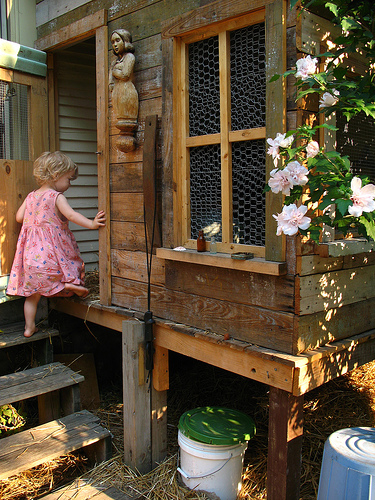

In [10]:
from IPython.display import Image
Image('/content/Flicker8k_Dataset/1000268201_693b08cb0e.jpg')

In [11]:
len(mapping)

8092

In [12]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            print(caption)
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Delete digits, special chars, etc.,
            caption = re.sub(r'[^a-zA-Z]', ' ', caption)
            # Delete additional spaces
            caption = re.sub(r'\s+', ' ', caption).strip()
            # Add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [13]:
clean(mapping)

Streaming output truncated to the last 5000 lines.
A dog is jumping over a log in a wooded area while carrying another log .
A dog with a stick in his mouth jumps over a fallen tree in the forest .
Dog carries stick and jumps over a log .
The dog carries a stick and jumps over a log in the woods .
The dog jumps over the log with a stick in its mouth .
A black and brown dog is running between two cement barriers with snow .
a dog runs down the cold aisle .
Black and tan small dog walking with perked ears .
The black and brown dog walks toward the camera , in an enclosed , snowy area .
The brown and black dog is running through a snowy street .
A furry dog is running through a doorway leading to plants .
A furry , tan dog is outside on a patio .
A short , furry dog stands on a brick floor in front of a group of potted plants .
A very hairy dog is running down a hall .
Flowers are behind the fluffy dog that is coming up the step .
A brown and black dog runs through the leaves .
A brown do

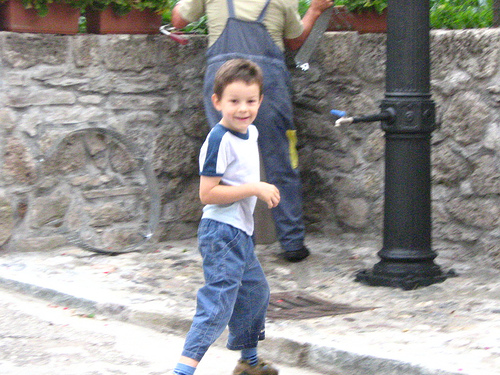

In [ ]:
from IPython.display import Image
Image('/content/Flicker8k_Dataset/1015118661_980735411b.jpg')

In [14]:
mapping['1015118661_980735411b']

['startseq boy smiles in front of stony wall in city endseq',
 'startseq little boy is standing on the street while man in overalls is working on stone wall endseq',
 'startseq young boy runs aross the street endseq',
 'startseq young child is walking on stone paved street with metal pole and man behind him endseq',
 'startseq smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him endseq']

In [15]:
#testing a few image mappings
i = 0
for key, captions in mapping.items():
  print(key+": ",captions)
  i += 1
  if(i==5): break

1000268201_693b08cb0e:  ['startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']
1001773457_577c3a7d70:  ['startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tri colored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq']
1002674143_1b742ab4b8:  ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq', 'startseq little girl is sitting in front of large painted rainbow endseq', 'startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it end

In [16]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [17]:
len(all_captions)
#unique captions

40459

In [18]:
all_captions[:10]

['startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq']

In [19]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [20]:
print(vocab_size)

8426


In [21]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [22]:
#Train Test and split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [23]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size, skip_images=None):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            # Check if key should be skipped
            if skip_images and key in skip_images:
                continue  # Skip this image
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

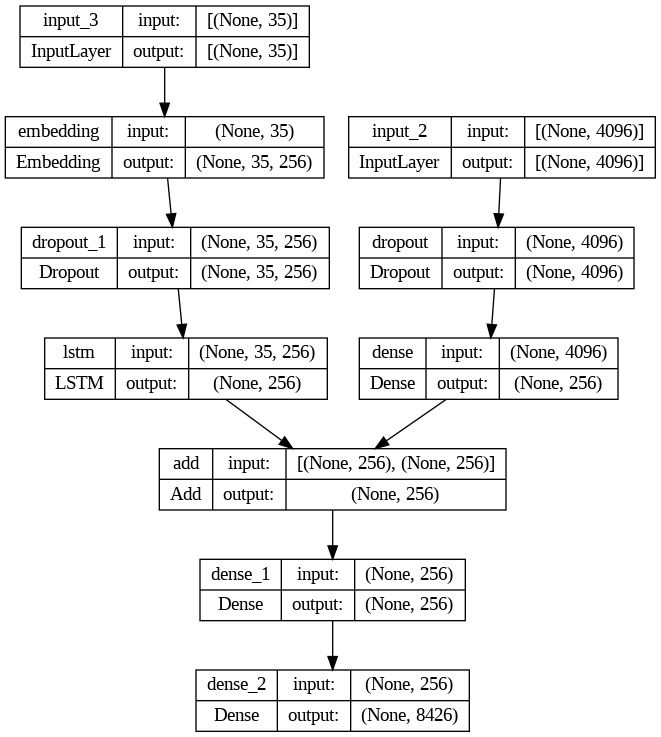

In [24]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
#Using relu activation function to extract features from fixed length input
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
#Using softmax activation function helps in predicting next word in sequence
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

epochs = 10
batch_size = 64
steps = len(train) // batch_size #floor division operator in Python

'''
# Define the filepath to save the model checkpoints
checkpoint_path = "/content/drive/MyDrive/Img_caption_models/model_checkpoint.h5"

# Define a callback to save the model after each epoch
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=True,
                                      save_best_only=True)
'''
for i in range(epochs):
    # create data generator
    images_to_skip = ['2258277193_586949ec62']  # Add image IDs you want to skip
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size, skip_images=images_to_skip)

    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
model.save("/content/drive/MyDrive/Img_caption_models/trained_model1.h5")

In [25]:
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Img_caption_models/trained_model1.h5")

In [26]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [27]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text


In [28]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    print(y_pred)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

startseq man in red shirt is standing on the air endseq
startseq dog is digging in the air endseq
startseq man in black jacket and black jacket is standing in front of building endseq
startseq man in red jacket and black jacket is sitting in front of window endseq
startseq man in green shirt is sitting on the street endseq
startseq man in red coat and red jacket and red jacket and red jacket and red jacket and red jacket and red jacket and red jacket and red jacket and red jacket and red jacket and
startseq man in blue shirt is sitting on the ground endseq
startseq two boys are playing soccer endseq
startseq person is walking on the edge of the edge of the water endseq
startseq man in white shorts is jumping on the ocean endseq
startseq two dogs are playing with ball in the grass endseq
startseq two little girls are standing on the bed endseq
startseq two dogs are playing with dog in the grass endseq
startseq man in red and white jacket is walking down the street endseq
startseq people

In [29]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(BASE_DIR,image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [ ]:
generate_caption('Flicker8k_Dataset',"1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq two people are standing on the street endseq


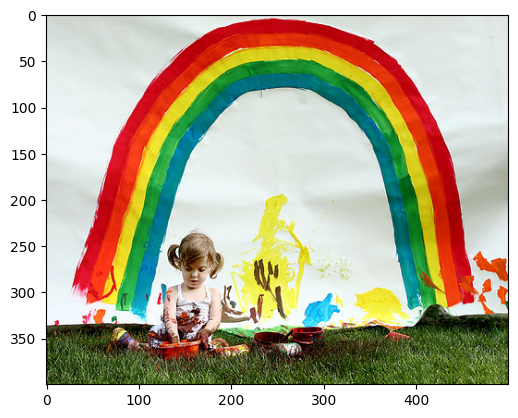

In [36]:
generate_caption('Flicker8k_Dataset',"1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq black and white dog is running in grassy garden surrounded by white fence endseq
startseq black and white dog is running through the grass endseq
startseq boston terrier is running in the grass endseq
startseq boston terrier is running on lush green grass in front of white fence endseq
startseq dog runs on the green grass near wooden fence endseq
--------------------Predicted--------------------
startseq dog is running through the grass endseq


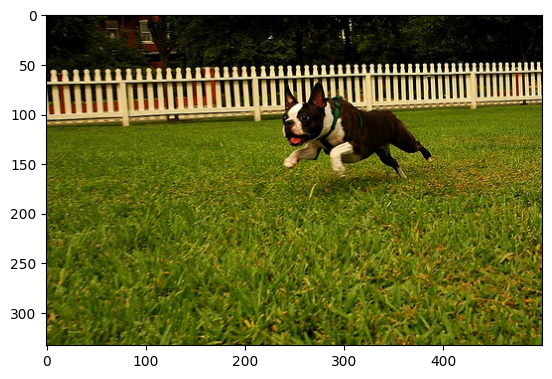

In [38]:
generate_caption('Flicker8k_Dataset',"1009434119_febe49276a.jpg")

---------------------Actual---------------------
startseq dog prepares to catch thrown object in field with nearby cars endseq
startseq white dog is about to catch yellow ball in its mouth endseq
startseq white dog is about to catch yellow dog toy endseq
startseq white dog is ready to catch yellow ball flying through the air endseq
startseq white dog running after yellow ball endseq
--------------------Predicted--------------------
startseq white dog is running on the grass endseq


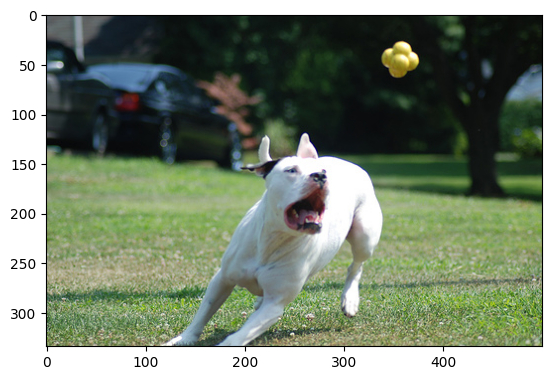

In [39]:
generate_caption('Flicker8k_Dataset',"1019604187_d087bf9a5f.jpg")

---------------------Actual---------------------
startseq boy in red and white shirt is on swing endseq
startseq child looking back on fast moving swing endseq
startseq litlle boy playing on swing endseq
startseq young boy in orange and white swings in playground at park endseq
startseq young boy plays on swing endseq
--------------------Predicted--------------------
startseq little boy is swinging on swing endseq


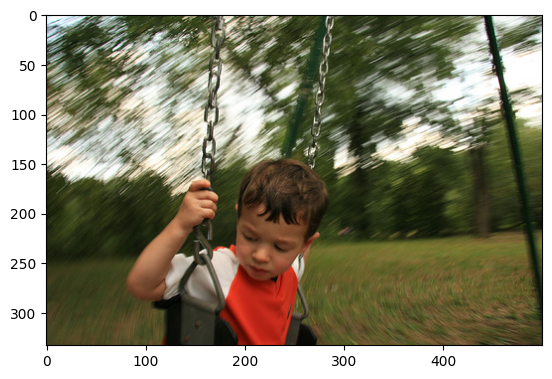

In [40]:
generate_caption('Flicker8k_Dataset',"1222322358_225067636e.jpg")

An image caption generator is typically built using deep learning techniques, particularly using a combination of Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs), or variants like Long Short-Term Memory (LSTM) networks or Transformer models. Here's a simplified overview of how it works:

Preprocessing the Images:

Images are preprocessed using a CNN. This involves passing the image through several convolutional layers, which extract features from the image. The output of the CNN is a feature vector that represents the content of the image.
Training Data Preparation:

For training, you need a dataset with images and corresponding captions. Each image is paired with one or more captions describing it.
Model Architecture:

The model architecture typically consists of two main parts: an image encoder and a text decoder.
The image encoder processes the image features extracted by the CNN. It transforms these features into a fixed-size vector that represents the image content.
The text decoder, often an RNN or LSTM, takes this fixed-size vector and generates a sequence of words that form the caption.
Training the Model:

During training, the model learns to predict captions from images by minimizing a loss function that measures the dissimilarity between the predicted captions and the ground truth captions.
The image features are fed into the image encoder, which generates a fixed-size representation of the image.
This representation is then fed into the text decoder, which generates a sequence of words one step at a time. At each step, the decoder predicts the next word in the sequence based on the previous words and the image representation.
Generating Captions:

Once the model is trained, it can generate captions for new images.
To generate a caption, you pass an image through the image encoder to get its feature vector.
Then, you feed this feature vector into the text decoder, which generates words one by one until it predicts an end-of-sequence token or reaches a maximum length.
Evaluation:

The quality of generated captions is evaluated using metrics like BLEU (Bilingual Evaluation Understudy), METEOR (Metric for Evaluation of Translation with Explicit Ordering), CIDEr (Consensus-based Image Description Evaluation), etc.
These metrics compare the generated captions with reference captions to assess how well they capture the content and style of the image.
Fine-tuning and Optimization:

The model may be fine-tuned or optimized using techniques like beam search, attention mechanisms, or reinforcement learning to improve caption quality and fluency.
Overall, an image caption generator combines computer vision techniques for image understanding with natural language processing techniques for text generation, resulting in a model capable of describing the content of images with human-like captions.








In [35]:
#metric - BiLingual Evaluation Understudy